In [1]:
def concat(df, columns):
    return np.array([''.join(x) for x in np.array(
        [np.array(df[col].values, dtype=str) for col in columns]).T])
from sklearn import metrics

In [2]:
# With the goal above, I will import just what I need. 
# The model to use (I already imported it above, but will do it again here so each example is self-contained)
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
# The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score

# An efficient data structure. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import the data
X = pd.read_csv("prep_trn_final.csv")
test_d = pd.read_csv("prep_test_final.csv")

In [3]:
z = X.pop("cost_final")
y  = X.pop("policy_f")



In [4]:
#on final test
z_t = test_d.pop("cost_final")
y_t  = test_d.pop("policy_f")



In [5]:
X.head()

,Unnamed: 0,customer_ID,C_previous,age_oldest,age_youngest,car_age,car_value,conf,conf_init,day,...,caCost,ppCost,stCost,costG,costStG,state_exp,location_exp,car_value_exp,prev_G,rand
0,4050,217,3,28,28,10,e,1734,1734,3,...,66.727273,734.0,658.954073,629.393124,658.868018,0.907966,1.149549,1.945779,1,0.010374
1,199426,233,3,62,60,3,d,2629,2630,2,...,157.500000,315.0,643.808683,640.104863,657.156472,2.369883,2.664088,2.000945,3,0.501875
2,197104,245,2,21,21,7,d,3708,3688,1,...,86.000000,688.0,628.728681,644.740444,646.445350,2.285245,2.125976,1.800660,3,0.495773
3,52831,253,1,31,31,2,f,2610,2625,0,...,208.333333,312.5,644.147616,640.104863,644.903539,2.506637,2.095289,2.431602,2,0.133830
4,56126,257,3,52,17,15,d,1607,1603,0,...,37.687500,301.5,622.373051,629.393124,578.796243,2.089581,2.060879,1.836977,1,0.142111


In [6]:

X["C_previous"].fillna(X.C_previous.mean(), inplace=True)
X["duration_previous"].fillna(X.C_previous.mean(), inplace=True)
X["risk_factor"].fillna(2, inplace=True)
X["prev_G"].fillna(4, inplace=True)

X["costG"].fillna(X.costG.mean(), inplace=True)
X["stCost"].fillna(X.stCost.mean(), inplace=True)
# Confirm the code is correct
X.describe()

,Unnamed: 0,customer_ID,C_previous,age_oldest,age_youngest,car_age,conf,conf_init,day,duration_previous,...,caCost,ppCost,stCost,costG,costStG,state_exp,location_exp,car_value_exp,prev_G,rand
count,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.00000,...,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000
mean,198045.790225,152720.548113,2.401815,45.070009,42.641399,8.201321,2805.797762,2808.184916,1.948849,5.92436,...,116.591514,567.348000,638.578168,638.738071,639.067378,2.174064,2.177196,2.182845,2.165216,0.499758
std,114348.268485,88011.060825,1.073167,17.387224,17.464855,5.779591,955.666820,953.149559,1.447871,4.70899,...,103.177084,142.299099,15.472060,6.706024,22.441887,0.574510,0.546678,0.217053,0.945111,0.288625
min,7.000000,217.000000,0.000000,18.000000,16.000000,0.000000,1400.000000,1393.000000,0.000000,0.00000,...,6.304348,120.333333,598.448454,629.393124,554.337910,0.863012,0.883856,1.284211,1.000000,0.000006
25%,99022.000000,76876.000000,1.000000,29.000000,26.000000,3.000000,1668.000000,1670.000000,1.000000,2.00000,...,49.666667,565.000000,624.186428,629.393124,631.896865,2.075900,1.932408,2.015053,1.000000,0.250036
50%,198182.000000,151795.000000,3.000000,44.000000,40.000000,8.000000,2658.000000,2661.000000,2.000000,5.00000,...,75.125000,623.000000,642.487070,640.104863,644.903539,2.328635,2.270266,2.186078,2.000000,0.498260
75%,296998.000000,228876.000000,3.000000,60.000000,57.000000,12.000000,3641.000000,3641.000000,3.000000,9.00000,...,146.675000,659.000000,652.372236,644.740444,655.988346,2.557409,2.555087,2.356052,3.000000,0.749644
max,396210.000000,305653.000000,4.000000,75.000000,75.000000,85.000000,4827.000000,4834.000000,6.000000,15.00000,...,819.000000,869.000000,663.803262,645.742917,689.121245,3.155253,3.684365,2.757420,4.000000,0.999996


In [7]:
#on test
test_d["C_previous"].fillna(test_d.C_previous.mean(), inplace=True)
test_d["duration_previous"].fillna(test_d.C_previous.mean(), inplace=True)
test_d["risk_factor"].fillna(2, inplace=True)
test_d["prev_G"].fillna(4, inplace=True)

test_d["costG"].fillna(test_d.costG.mean(), inplace=True)
test_d["stCost"].fillna(test_d.stCost.mean(), inplace=True)

In [8]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()


,Unnamed: 0,customer_ID,C_previous,age_oldest,age_youngest,car_age,conf,conf_init,day,duration_previous,...,caCost,ppCost,stCost,costG,costStG,state_exp,location_exp,car_value_exp,prev_G,rand
0,4050,217,3,28,28,10,1734,1734,3,13,...,66.727273,734.0,658.954073,629.393124,658.868018,0.907966,1.149549,1.945779,1,0.010374
1,199426,233,3,62,60,3,2629,2630,2,3,...,157.500000,315.0,643.808683,640.104863,657.156472,2.369883,2.664088,2.000945,3,0.501875
2,197104,245,2,21,21,7,3708,3688,1,4,...,86.000000,688.0,628.728681,644.740444,646.445350,2.285245,2.125976,1.800660,3,0.495773
3,52831,253,1,31,31,2,2610,2625,0,13,...,208.333333,312.5,644.147616,640.104863,644.903539,2.506637,2.095289,2.431602,2,0.133830
4,56126,257,3,52,17,15,1607,1603,0,0,...,37.687500,301.5,622.373051,629.393124,578.796243,2.089581,2.060879,1.836977,1,0.142111


In [9]:

categorical_variables = ['C_previous','risk_factor','homeowner','married_couple']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    #X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [10]:
#on test
categorical_variables = ['C_previous','risk_factor','homeowner','married_couple']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    #X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(test_d[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    test_d = pd.concat([test_d, dummies], axis=1)
    test_d.drop([variable], axis=1, inplace=True)

In [11]:
#these are imp
#X.drop(["customer_ID","price","costG","policy+shopping_pt","state+policy", "time","location","conf","conf_init","policy_f"], axis=1, inplace=True)

In [12]:
#on test
test_d.drop(["costG","conf","conf_init","time","location","shopping_pt","record_type","day","state","car_value"], axis=1, inplace=True)

In [13]:
X.drop(["costG","conf","conf_init","time","location","shopping_pt","record_type","day","rand","state","car_value"], axis=1, inplace=True)


In [14]:
test_d.head()

,Unnamed: 0,customer_ID,age_oldest,age_youngest,car_age,duration_previous,group_size,caCost,ppCost,stCost,...,C_previous_3.0,C_previous_4.0,risk_factor_1.0,risk_factor_2.0,risk_factor_3.0,risk_factor_4.0,homeowner_0,homeowner_1,married_couple_0,married_couple_1
0,129,207,46,42,2,2,2,211.000000,316.5,619.722766,...,0,0,0,0,1,0,1,0,0,1
1,141,221,43,43,11,4,1,51.583333,619.0,644.147616,...,0,0,0,1,0,0,1,0,1,0
2,163,235,32,28,5,2,1,98.000000,588.0,615.294640,...,0,0,0,0,1,0,1,0,0,1
3,153,239,24,24,6,9,1,83.857143,587.0,622.373051,...,1,0,0,1,0,0,1,0,1,0
4,205,263,44,20,1,2,2,347.500000,347.5,642.487070,...,0,0,1,0,0,0,0,1,1,0


In [15]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(test_d.describe())

,Unnamed: 0,customer_ID,age_oldest,age_youngest,car_age,duration_previous,group_size,caCost,ppCost,stCost,costStG,state_exp,location_exp,car_value_exp,prev_G,C_previous_0.0,C_previous_1.0,C_previous_2.0,C_previous_3.0,C_previous_4.0,risk_factor_1.0,risk_factor_2.0,risk_factor_3.0,risk_factor_4.0,homeowner_0,homeowner_1,married_couple_0,married_couple_1
count,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.00000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000
mean,29346.000000,154693.441082,45.155013,42.819907,8.213317,5.789409,1.23165,115.866024,567.007042,638.563325,638.327299,2.174405,2.180660,2.182451,2.097492,0.040891,0.249949,0.162748,0.407279,0.139133,0.150685,0.506577,0.178696,0.164043,0.451203,0.548797,0.795202,0.204798
std,16943.209672,88296.818499,17.435385,17.493880,5.803750,4.773281,0.46140,102.759688,142.713599,15.400258,22.771195,0.541791,0.509567,0.107314,0.945509,0.198042,0.432991,0.369142,0.491336,0.346091,0.357748,0.499965,0.383104,0.370321,0.497622,0.497622,0.403561,0.403561
min,1.000000,207.000000,18.000000,16.000000,0.000000,0.000000,1.00000,7.772727,134.750000,598.448454,554.337910,1.015281,1.038273,1.502514,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14673.500000,78320.000000,29.000000,27.000000,4.000000,2.000000,1.00000,49.727273,561.000000,625.466155,631.495694,2.246192,1.995414,2.176413,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,29346.000000,155650.000000,44.000000,40.000000,8.000000,4.000000,1.00000,74.472222,620.000000,642.487070,644.903539,2.345511,2.306548,2.176413,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,44018.500000,231480.000000,60.000000,57.000000,12.000000,9.000000,1.00000,142.500000,659.000000,652.372236,654.417266,2.474777,2.540438,2.230369,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,58691.000000,305655.000000,75.000000,75.000000,74.000000,15.000000,4.00000,898.000000,898.000000,663.803262,689.121245,2.743858,3.254788,2.393963,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X.describe())

,Unnamed: 0,customer_ID,age_oldest,age_youngest,car_age,duration_previous,group_size,caCost,ppCost,stCost,costStG,state_exp,location_exp,car_value_exp,prev_G,C_previous_0.0,C_previous_1.0,C_previous_2.0,C_previous_3.0,C_previous_4.0,risk_factor_1.0,risk_factor_2.0,risk_factor_3.0,risk_factor_4.0,homeowner_0,homeowner_1,married_couple_0,married_couple_1
count,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.00000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000
mean,198045.790225,152720.548113,45.070009,42.641399,8.201321,5.92436,1.233436,116.591514,567.348000,638.578168,639.067378,2.174064,2.177196,2.182845,2.165216,0.017986,0.259536,0.167314,0.413003,0.142160,0.150363,0.504397,0.176463,0.168778,0.456409,0.543591,0.790668,0.209332
std,114348.268485,88011.060825,17.387224,17.464855,5.779591,4.70899,0.459624,103.177084,142.299099,15.472060,22.441887,0.574510,0.546678,0.217053,0.945111,0.132902,0.438383,0.373259,0.492377,0.349217,0.357429,0.499984,0.381216,0.374558,0.498100,0.498100,0.406834,0.406834
min,7.000000,217.000000,18.000000,16.000000,0.000000,0.00000,1.000000,6.304348,120.333333,598.448454,554.337910,0.863012,0.883856,1.284211,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99022.000000,76876.000000,29.000000,26.000000,3.000000,2.00000,1.000000,49.666667,565.000000,624.186428,631.896865,2.075900,1.932408,2.015053,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,198182.000000,151795.000000,44.000000,40.000000,8.000000,5.00000,1.000000,75.125000,623.000000,642.487070,644.903539,2.328635,2.270266,2.186078,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,296998.000000,228876.000000,60.000000,57.000000,12.000000,9.00000,1.000000,146.675000,659.000000,652.372236,655.988346,2.557409,2.555087,2.356052,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,396210.000000,305653.000000,75.000000,75.000000,85.000000,15.00000,4.000000,819.000000,869.000000,663.803262,689.121245,3.155253,3.684365,2.757420,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
MultiLabelBinarizer(y)

MultiLabelBinarizer(classes=0        1
1        2
2        3
3        2
4        1
5        3
6        1
7        2
8        3
9        2
10       3
11       3
12       3
13       3
14       1
15       2
16       1
17       2
18       1
19       1
20       4
21       3
22       1
23       1
24       3
25       3
26    ...    3
67657    2
67658    2
67659    3
67660    3
67661    3
67662    3
Name: policy_f, dtype: int64,
          sparse_output=False)

In [18]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = .3 )

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split( X_train, y_train, test_size = .3 )

In [20]:
y_train.describe()


count    33154.000000
mean         2.165742
std          0.947960
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: policy_f, dtype: float64

In [21]:

model = RandomForestClassifier(50, oob_score=True, n_jobs=-1, random_state=42)
model.fit( X_train, y_train )

#over test data
predicted_test  = model.predict( X_test )
expected_test   = y_test
confusionMatrix_test = metrics.confusion_matrix( expected_test, predicted_test )

#over test data
predicted_valid  = model.predict( X_valid )
expected_valid   = y_valid
confusionMatrix_valid = metrics.confusion_matrix( expected_valid, predicted_valid )


In [22]:
#over the final test-predicting data
predicted_final  = model.predict( test_d )


In [23]:
test_d['plan'] = predicted_final

In [24]:
test_d.head()

,Unnamed: 0,customer_ID,age_oldest,age_youngest,car_age,duration_previous,group_size,caCost,ppCost,stCost,...,C_previous_4.0,risk_factor_1.0,risk_factor_2.0,risk_factor_3.0,risk_factor_4.0,homeowner_0,homeowner_1,married_couple_0,married_couple_1,plan
0,129,207,46,42,2,2,2,211.000000,316.5,619.722766,...,0,0,0,1,0,1,0,0,1,3
1,141,221,43,43,11,4,1,51.583333,619.0,644.147616,...,0,0,1,0,0,1,0,1,0,1
2,163,235,32,28,5,2,1,98.000000,588.0,615.294640,...,0,0,0,1,0,1,0,0,1,3
3,153,239,24,24,6,9,1,83.857143,587.0,622.373051,...,0,0,1,0,0,1,0,1,0,2
4,205,263,44,20,1,2,2,347.500000,347.5,642.487070,...,0,1,0,0,0,0,1,1,0,3


In [25]:
test_d.to_csv("predited_data_policy.csv")

In [26]:
#over test
acc_test= metrics.accuracy_score(expected_test,predicted_test,normalize=True, sample_weight= None)
prec_test = metrics.precision_score(expected_test,predicted_test,labels=None,pos_label=1,average='macro', sample_weight= None)
recall_test = metrics.recall_score(expected_test,predicted_test,labels=None,pos_label=None,average='micro', sample_weight= None)

In [27]:
#over test
acc_valid= metrics.accuracy_score(expected_valid,predicted_valid,normalize=True, sample_weight= None)
prec_valid = metrics.precision_score(expected_valid,predicted_valid,labels=None,pos_label=1,average='macro', sample_weight= None)
recall_valid = metrics.recall_score(expected_valid,predicted_valid,labels=None,pos_label=None,average='micro', sample_weight= None)

In [30]:
#print the confusion matrix for validation set and test set
print(confusionMatrix_valid)

[[4372   63  136   19]
 [  71 3101  307   20]
 [ 117  219 4821  100]
 [  27   29  155  653]]


In [31]:
print(confusionMatrix_test)

[[6167   73  193   29]
 [  93 4481  432   38]
 [ 183  346 6988  112]
 [  39   35  221  869]]


In [32]:
print("test scores : accuracy ",acc_test , " precision: ",prec_test, " recall ",recall_test)
print("Validation scores : accuracy ",acc_valid , " precision: ",prec_valid, " recall ",recall_valid)

test scores : accuracy  0.911621262131  precision:  0.895153901091  recall  0.911621262131
Validation scores : accuracy  0.911118930331  precision:  0.894030501506  recall  0.911118930331


In [33]:
metrics.f1_score(expected_test,predicted_test,labels=None,pos_label=None,average='micro', sample_weight= None)

0.91162126213113948

In [34]:
model.oob_score_

0.90897025999879355

In [35]:
model.n_classes_

4

In [36]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

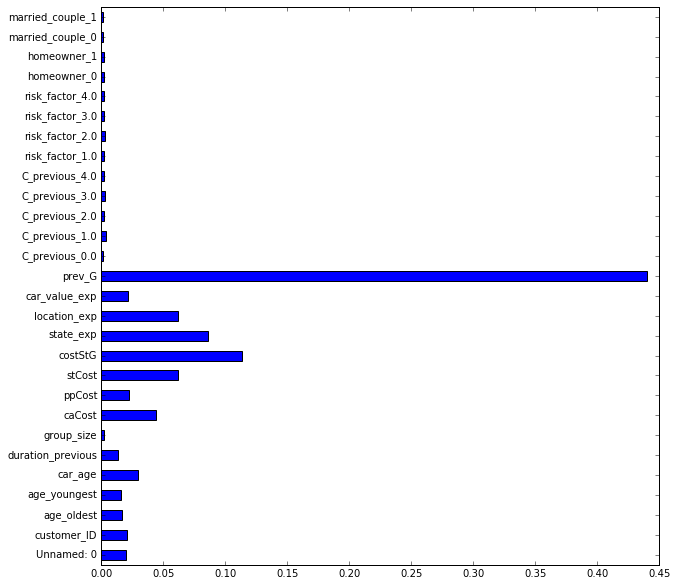

In [37]:
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values()
feature_importances.plot(kind="barh", figsize=(10,10));

In [38]:

# Now the Regression:
#for that first we need to merge the result of prediction to X

#merging the final policy in the training set
X['plan'] = y
# the final test set already have a column plan which has predicted values



In [39]:
#now splitting the training data X and z = X.pop("cost_final"):
X_train, X_test, z_train, z_test = train_test_split( X, z, test_size = .3 )


In [40]:
#splitting the validation set
X_train, X_valid, z_train, z_valid = train_test_split( X_train, z_train, test_size = .3 )

In [41]:


# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, z_train)

# print intercept and coefficients
print (lm.intercept_)
print (lm.coef_)

-252.211328646
[ -9.30106829e-08  -1.71151212e-06  -6.01394783e-02   1.00538916e-03
  -6.24215258e-01  -3.36818162e-01   1.70626361e+02   1.89177579e-02
   5.97311605e-01   3.97832705e-01   1.25237497e-01  -2.18925874e+00
  -4.06808328e-01   5.62715402e+00  -4.65711240e+00  -3.19576520e+00
   4.04724789e+00   1.03481548e+00  -5.17366545e-01  -1.36893162e+00
  -5.59447521e+00   2.49593204e+00   2.03086056e+00   1.06768261e+00
   2.99386536e+00  -2.99386536e+00  -2.84842914e+00   2.84842914e+00
   8.24146280e+00]


In [42]:
# pair the feature names with the coefficients
zip(X_train.columns, lm.coef_)

In [43]:
print(X_train.columns)

Index(['Unnamed: 0', 'customer_ID', 'age_oldest', 'age_youngest', 'car_age',
       'duration_previous', 'group_size', 'caCost', 'ppCost', 'stCost',
       'costStG', 'state_exp', 'location_exp', 'car_value_exp', 'prev_G',
       'C_previous_0.0', 'C_previous_1.0', 'C_previous_2.0', 'C_previous_3.0',
       'C_previous_4.0', 'risk_factor_1.0', 'risk_factor_2.0',
       'risk_factor_3.0', 'risk_factor_4.0', 'homeowner_0', 'homeowner_1',
       'married_couple_0', 'married_couple_1', 'plan'],
      dtype='object')


In [44]:
lm.predict(X_valid)

array([ 646.90771536,  646.64458426,  658.51089633, ...,  593.47164082,
        604.76236077,  731.68303946])

In [45]:
lm.predict(X_test)

array([ 740.08218637,  636.53512221,  674.98531961, ...,  613.51813594,
        707.11585879,  706.37393074])

In [46]:
# on the train data

# calculate the R-squared
lm.score(X_train, z_train)

0.70804636762956275

In [47]:
# on the valid data

# calculate the R-squared
lm.score(X_valid, z_valid)



0.70773614876860003

In [48]:
# on the testing data

# calculate the R-squared
lm.score(X_test, z_test)

0.69584564767276857

In [49]:
#changing parameters and selecting features
X_changed_para=X_train[['group_size','duration_previous', 'age_oldest', 'age_youngest' , 'stCost' , 'ppCost' , 'caCost' , 'car_age' , 'plan', 'state_exp']]

In [50]:
#now train it with few imp features
lm.fit(X_changed_para, z_train)

# print intercept and coefficients
print (lm.intercept_)
print (lm.coef_)


-256.142332427
[  1.80680410e+02  -4.57167245e-01  -2.14190135e-01   7.17964728e-02
   5.10293581e-01   6.19459182e-01   1.63233263e-02  -6.16902638e-01
   5.57904042e+00  -2.80364335e+00]


In [51]:
# calculate the R-squared
lm.score(X_changed_para, z_train)

0.69358273315121222

In [52]:
#check on validation set
X_valid_para=X_valid[['group_size','duration_previous', 'age_oldest', 'age_youngest' , 'stCost' , 'ppCost' , 'caCost' , 'car_age' , 'plan', 'state_exp']]

In [76]:
z_valid_pred = lm.predict(X_valid_para)

In [54]:
# calculate the R-squared on validation set
lm.score(X_valid_para, z_valid)

0.69313224692716757

In [55]:
#check on test set
X_test_para=X_test[['group_size','duration_previous', 'age_oldest', 'age_youngest' , 'stCost' , 'ppCost' , 'caCost' , 'car_age' , 'plan', 'state_exp']]

In [72]:
#test data
z_test_pred=lm.predict(X_test_para)

In [67]:
#score test
lm.score(X_test_para, z_test)

In [77]:
#Root mean squared error on our testing data
from sklearn.metrics import mean_squared_error
err_test = mean_squared_error(z_test, z_test_pred)**0.5

print("on the testing... Root mean square Error is ",err_test)



#Root mean squared error on our validation data

err_valid = mean_squared_error(z_valid, z_valid_pred)**0.5

print("on the Validating... Root mean square Error is ",err_valid)

on the testing... Root mean square Error is  24.2545065886
on the Validating... Root mean square Error is  23.7121793713


In [58]:
#now working on the final predicting data
test_d.head()

,Unnamed: 0,customer_ID,age_oldest,age_youngest,car_age,duration_previous,group_size,caCost,ppCost,stCost,...,C_previous_4.0,risk_factor_1.0,risk_factor_2.0,risk_factor_3.0,risk_factor_4.0,homeowner_0,homeowner_1,married_couple_0,married_couple_1,plan
0,129,207,46,42,2,2,2,211.000000,316.5,619.722766,...,0,0,0,1,0,1,0,0,1,3
1,141,221,43,43,11,4,1,51.583333,619.0,644.147616,...,0,0,1,0,0,1,0,1,0,1
2,163,235,32,28,5,2,1,98.000000,588.0,615.294640,...,0,0,0,1,0,1,0,0,1,3
3,153,239,24,24,6,9,1,83.857143,587.0,622.373051,...,0,0,1,0,0,1,0,1,0,2
4,205,263,44,20,1,2,2,347.500000,347.5,642.487070,...,0,1,0,0,0,0,1,1,0,3


In [59]:
#making final prediction
X_predict_para=test_d[['group_size','duration_previous', 'age_oldest', 'age_youngest' , 'stCost' , 'ppCost' , 'caCost' , 'car_age' , 'plan', 'state_exp']]

In [60]:
lm.predict(X_predict_para)

array([ 622.14966155,  621.92513143,  605.05011366, ...,  719.74102921,
        690.1583616 ,  686.94531043])

In [61]:
test_d['price']=lm.predict(X_predict_para)

In [62]:
test_d.head()

,Unnamed: 0,customer_ID,age_oldest,age_youngest,car_age,duration_previous,group_size,caCost,ppCost,stCost,...,risk_factor_1.0,risk_factor_2.0,risk_factor_3.0,risk_factor_4.0,homeowner_0,homeowner_1,married_couple_0,married_couple_1,plan,price
0,129,207,46,42,2,2,2,211.000000,316.5,619.722766,...,0,0,1,0,1,0,0,1,3,622.149662
1,141,221,43,43,11,4,1,51.583333,619.0,644.147616,...,0,1,0,0,1,0,1,0,1,621.925131
2,163,235,32,28,5,2,1,98.000000,588.0,615.294640,...,0,0,1,0,1,0,0,1,3,605.050114
3,153,239,24,24,6,9,1,83.857143,587.0,622.373051,...,0,1,0,0,1,0,1,0,2,600.355845
4,205,263,44,20,1,2,2,347.500000,347.5,642.487070,...,1,0,0,0,0,1,1,0,3,653.941077


In [63]:
final_submission=test_d[['customer_ID','plan','price']]

In [65]:
test_d.to_csv("final_after_predicting_data.csv")

In [66]:
final_submission.to_csv("submission_data.csv")